In [1]:
#Import the libraries
import pandas as pd 
import numpy as np 
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the compostion column nan values with 0
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)

In [6]:
# check if these columns have noisy data.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [7]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [8]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [9]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [10]:
# Select SS316 stainless steel and sub-sized data
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [11]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Irradiation Dose (mdpa)', 'Specimen Size Type',
                                       'Irradiation Temperature (C)','Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 21 to 907
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Material Group                   209 non-null    object 
 1   C (wt.%)                         209 non-null    float64
 2   Si (wt.%)                        209 non-null    float64
 3   Mn (wt.%)                        209 non-null    float64
 4   P (wt.%)                         209 non-null    float64
 5   S (wt.%)                         209 non-null    float64
 6   Ni (wt.%)                        209 non-null    float64
 7   Cr (wt.%)                        209 non-null    float64
 8   Mo (wt.%)                        209 non-null    float64
 9   Al (wt.%)                        209 non-null    float64
 10  N (wt.%)                         209 non-null    float64
 11  Ti (wt.%)                        209 non-null    float64
 12  Fe (wt.%)                 

In [13]:
# sort the dataframe by UTS values
tensile_df = tensile_df.sort_values(by='Ultimate Tensile Strength (MPa)').reset_index(drop=True)


In [14]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Ultimate Tensile Strength (MPa)'])

In [15]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure input features are float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input features and input targets variables
features = input_features_df
targets = tensile_df['Ultimate Tensile Strength (MPa)']

In [18]:
# define the coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=6.2736 val_loss=6.1216 scale=1.0000 norm=0.5178


[iter 100] loss=5.9319 val_loss=5.8515 scale=1.0000 norm=0.3868
[iter 200] loss=5.6543 val_loss=5.6021 scale=2.0000 norm=0.7947
[iter 300] loss=5.3070 val_loss=5.3016 scale=2.0000 norm=0.7919
[iter 400] loss=5.0208 val_loss=5.1119 scale=2.0000 norm=0.7574
== Early stopping achieved.
== Best iteration / VAL475 (val_loss=5.0447)
Pearson CC: 0.9115303653530156
R2 score: 0.8278445547890104
RMSE: 63.75399170095732
MAE: 42.47267651514311
Coverage: 95.23809523809524
Median Interval Width: 150.40870129945782
Composite Metric: 0.7159478521663032


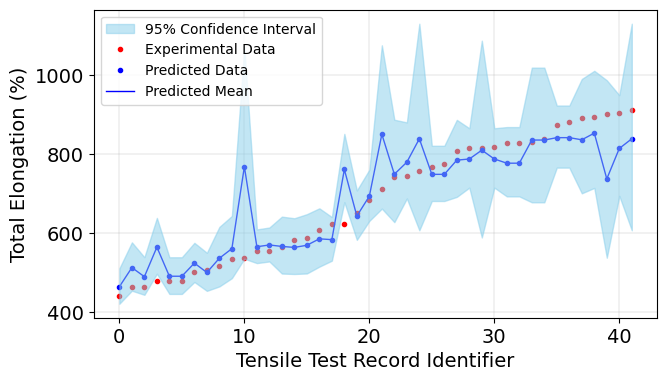

Run # 1 Fold # 2
[iter 0] loss=6.3559 val_loss=6.2519 scale=1.0000 norm=0.4847
[iter 100] loss=6.0411 val_loss=5.9547 scale=1.0000 norm=0.3777
[iter 200] loss=5.7286 val_loss=5.6354 scale=2.0000 norm=0.7801
[iter 300] loss=5.4021 val_loss=5.3120 scale=1.0000 norm=0.3811
[iter 400] loss=5.1311 val_loss=5.0547 scale=2.0000 norm=0.7199
[iter 500] loss=4.9260 val_loss=4.8982 scale=2.0000 norm=0.6792
[iter 600] loss=4.7724 val_loss=4.8073 scale=2.0000 norm=0.6584
== Early stopping achieved.
== Best iteration / VAL656 (val_loss=4.7624)
Pearson CC: 0.9514006608828676
R2 score: 0.8999342064300794
RMSE: 37.46903354860581
MAE: 27.697868398903932
Coverage: 95.23809523809524
Median Interval Width: 108.68711488367484
Composite Metric: 0.7165858949489656


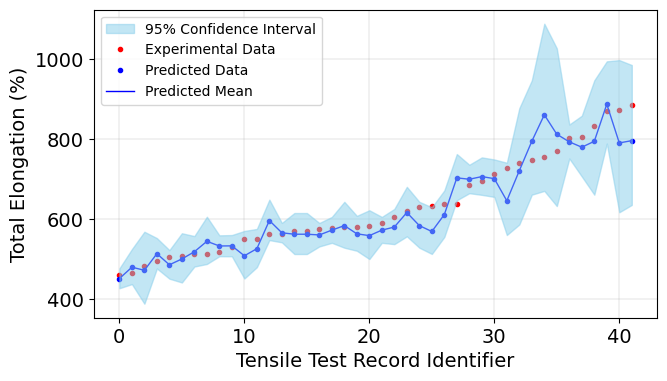

Run # 1 Fold # 3
[iter 0] loss=6.3166 val_loss=6.1929 scale=1.0000 norm=0.4898
[iter 100] loss=5.9718 val_loss=5.9530 scale=1.0000 norm=0.3788
[iter 200] loss=5.6295 val_loss=5.7251 scale=2.0000 norm=0.7943
[iter 300] loss=5.2803 val_loss=5.5971 scale=2.0000 norm=0.7892
[iter 400] loss=5.0019 val_loss=5.5460 scale=2.0000 norm=0.7736
== Early stopping achieved.
== Best iteration / VAL403 (val_loss=5.5452)
Pearson CC: 0.9114526413628388
R2 score: 0.827894622960254
RMSE: 59.112332808527185
MAE: 40.82652016287599
Coverage: 95.23809523809524
Median Interval Width: 171.49398873880637
Composite Metric: 0.7157434913299042


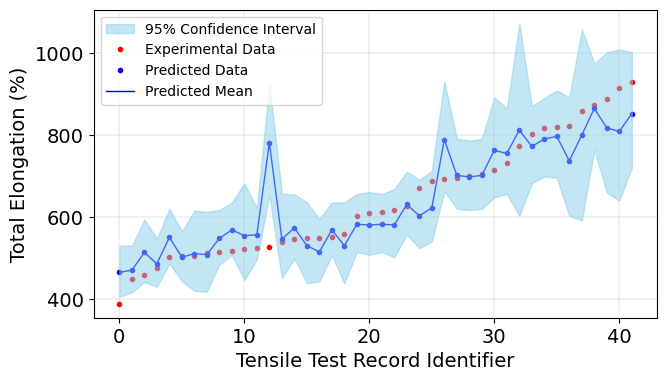

Run # 1 Fold # 4
[iter 0] loss=6.3362 val_loss=6.2218 scale=1.0000 norm=0.4649
[iter 100] loss=6.0065 val_loss=5.9227 scale=1.0000 norm=0.3704
[iter 200] loss=5.6820 val_loss=5.5868 scale=2.0000 norm=0.7841
[iter 300] loss=5.3378 val_loss=5.2213 scale=2.0000 norm=0.7929
[iter 400] loss=5.0511 val_loss=4.9201 scale=2.0000 norm=0.7674
[iter 500] loss=4.8375 val_loss=4.7235 scale=2.0000 norm=0.7391
[iter 600] loss=4.6732 val_loss=4.6170 scale=2.0000 norm=0.7164
== Early stopping achieved.
== Best iteration / VAL648 (val_loss=4.6027)
Pearson CC: 0.8617961336928419
R2 score: 0.736018186589082
RMSE: 67.51578845035834
MAE: 46.754353923003265
Coverage: 76.19047619047619
Median Interval Width: 97.17768331837857
Composite Metric: 0.5740011785484689


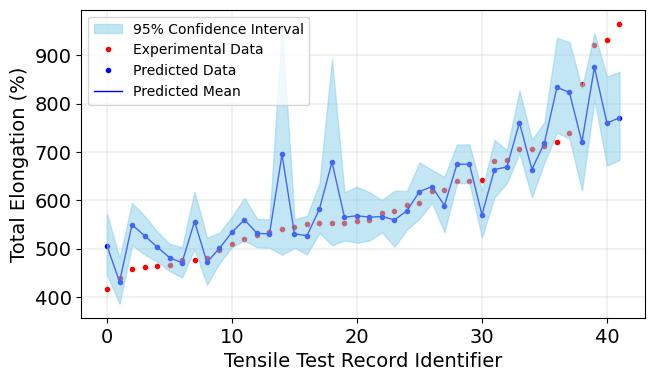

Run # 1 Fold # 5
[iter 0] loss=6.3285 val_loss=6.2739 scale=1.0000 norm=0.4677
[iter 100] loss=5.9925 val_loss=5.9498 scale=2.0000 norm=0.7414
[iter 200] loss=5.6050 val_loss=5.5909 scale=2.0000 norm=0.8015
[iter 300] loss=5.2856 val_loss=5.3591 scale=2.0000 norm=0.7800
[iter 400] loss=5.0199 val_loss=5.2419 scale=2.0000 norm=0.7511
== Early stopping achieved.
== Best iteration / VAL433 (val_loss=5.2315)
Pearson CC: 0.9093855305134622
R2 score: 0.7838639582550679
RMSE: 62.16875488689336
MAE: 40.66168097116066
Coverage: 100.0
Median Interval Width: 166.51745843762376
Composite Metric: 0.7515013440773458


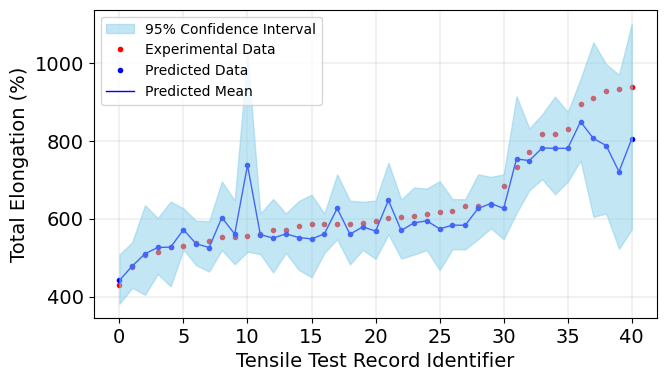

In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
            
            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            
            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            
            
            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))
            
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            
            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]
            
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high) 
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Total Elongation (%)", fontsize=14)
            ax[0].tick_params(axis='x', labelsize=14)  
            ax[0].tick_params(axis='y', labelsize=14)   

            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
            plt.show()

In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.911530,0.827845,63.753992,42.472677,95.238095
1,0.951401,0.899934,37.469034,27.697868,95.238095
2,0.911453,0.827895,59.112333,40.826520,95.238095
3,0.861796,0.736018,67.515788,46.754354,76.190476
4,0.909386,0.783864,62.168755,40.661681,100.000000


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.909113,0.02842,0.815111,0.054319,58.00398,10.618804,39.68262,6.382714,92.380952,8.302665


In [22]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,95.238095,150.408701,0.715948
1,95.238095,108.687115,0.716586
2,95.238095,171.493989,0.715743
3,76.190476,97.177683,0.574001
4,100.000000,166.517458,0.751501


In [23]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.380952,8.302665,138.856989,30.368086,0.694756,0.061916
